# Exploring a rose garden with SPARQL

*Philippe Rocca-Serra (philippe.rocca-serra[at]oerc.ox.ac.uk), University of Oxford e-Research Centre

In [1]:
from rdflib import Graph, RDF
from IPython.core.display import display, HTML
import os
import json
import csv
import uuid

from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, JSONLD, CSV, TSV, N3, RDF, RDFXML, TURTLE
import pandas as pds
import itertools

import numpy as np
from plotnine import *


In [2]:
def queryResultToHTMLTable(queryResult):
   HTMLResult = '<table><tr style="color:white;background-color:#43BFC7;font-weight:bold">'
   # print variable names
   for varName in queryResult.vars:
       HTMLResult = HTMLResult + '<td>' + varName + '</td>'
   HTMLResult = HTMLResult + '</tr>'
   # print values from each row
   for row in queryResult:
      HTMLResult = HTMLResult + '<tr>'   
      for column in row:
         HTMLResult = HTMLResult + '<td>' + column + '</td>'
      HTMLResult = HTMLResult + '</tr>'
   HTMLResult = HTMLResult + '</table>'
   display(HTML(HTMLResult))

In [3]:
def get_sparql_variables(results, sparql_wrapper="SPARQLWrapper2"):
#     return results.vars if ("sparqlwrapper2" == sparql_wrapper.lower()) else results['head']['vars']
    return results.vars if ("sparqlwrapper2" == sparql_wrapper.lower()) else results.vars
    print(results.vars)

def get_sparql_bindings(results, sparql_wrapper="SPARQLWrapper2"):
    return results.bindings if ("sparqlwrapper2" == sparql_wrapper.lower()) else results['results']['bindings']
   

def get_sparql_binding_variable_value(binding, variable, sparql_wrapper="SPARQLWrapper2"):
    return binding[variable].value if ("sparqlwrapper2" == sparql_wrapper.lower()) else binding[variable]['value']
   

def make_sparql_dict_list(bindings, variables, sparql_wrapper="SPARQLWrapper2"):
    def binding_value(binding, var): # helper function for returning values
        return get_sparql_binding_variable_value(binding, var, sparql_wrapper) if (var in binding) else None

    dict_list = []  # list to contain dictionaries
    for binding in itertools.chain(bindings):
        values = [binding_value(binding, var) for var in itertools.chain(variables)]
        dict_list.append(dict(zip(variables, values)))

    return dict_list


def make_sparql_df(results, sparql_wrapper="SPARQLWrapper2"):
    variables = get_sparql_variables(results, sparql_wrapper)

    cleaned_variables=[str(var.replace('\\n','')) for var in variables] 
    print(cleaned_variables)
    bindings = get_sparql_bindings(results, sparql_wrapper)

    # create a list of dictionaries to use as data for dataframe
    data_list = make_sparql_dict_list(bindings, cleaned_variables, sparql_wrapper)
    
    print(data_list)

    df = pds.DataFrame(data_list) # create dataframe from data list
    return df[cleaned_variables] # return dataframe with columns reordered

*credits to Bob du Charme for the following function [http://www.snee.com/bobdc.blog/2016/07/sparql-in-a-jupyter-aka-ipytho.html]

In [4]:
g = Graph()

Let's read the RDF graph generated using the rose-dtpkg2rdf.py python script and saved to disk as a turtle file

In [5]:
#g.parse("./rose-data-as-rdf/rose-aroma-test-subset.ttl", format="n3")
#g.parse("./rose-data-as-rdf/rose-aroma-one-group-2nd-test.ttl", format="n3")
g.parse("./rose-data-as-rdf/rose-aroma-full-latest-compound-test.ttl", format="n3")


<Graph identifier=N330cf41578ed49e58db91ce6690b81de (<class 'rdflib.graph.Graph'>)>

Now let's ask for the independent variables and their levels using the following SPARQL query

In [6]:
get_idv_and_levels = g.query("""
PREFIX stato: <http://purl.obolibrary.org/obo/STATO_>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
PREFIX ncbitax: <http://purl.obolibrary.org/obo/NCBITax_>
prefix ro: <http://purl.obolibrary.org/obo/RO_> 
            SELECT DISTINCT
             ?Predictor
             ?PredictorLevel
             WHERE { 
                ?var a stato:0000087 ;
                    rdfs:label ?Predictor;
                    ro:has_part ?value.
                ?value rdfs:label ?PredictorLevel    
                 }               
""")

We can display the results of that query using the function declared earlier on.

In [7]:
queryResultToHTMLTable(get_idv_and_levels)

Predictor,PredictorLevel
genotype,R. chinensis 'Old Blush'
genotype,R. Damascena
genotype,R. moschata
genotype,R. gigantea
genotype,R. wichurana
genotype,R. Gallica
organism part,sepal
organism part,stamen
organism part,petal


Let's now ask for the number of biological and technical replicates used to compute the mean concentration of the chemical compounds detected and forming the signature of the rose fragrance.

In [8]:
get_replication_info = g.query("""
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
prefix chmo:   <http://purl.obolibrary.org/obo/CHMO_> 
prefix msio:   <http://purl.obolibrary.org/obo/MSIO_> 
prefix stato: <http://purl.obolibrary.org/obo/STATO_> 
prefix obi: <http://purl.obolibrary.org/obo/OBI_> 
prefix ro: <http://purl.obolibrary.org/obo/RO_>
prefix po: <http://purl.obolibrary.org/obo/PO_>

SELECT        
      ?TreatmentGroup        
      (count(distinct ?member) as ?NbTechnicalReplicate) 
      (count(distinct ?input) as ?NbBiologicalReplicate) 
      WHERE {
            ?population a stato:0000193 ;
                rdfs:label ?TreatmentGroup ;
                ro:has_member ?member .      
            ?member ro:has_specified_input ?input .              
            ?mean a stato:0000402 ;
                stato:computed_over ?population ;
                ro:has_value ?MeanConcentration ;
                ro:is_about ?ChemicalCompound .
            ?concentration a stato:0000072;
                ro:is_specified_output_of ?assay ;
                ro:is_about ?ChemicalCompound .
            }
      GROUP BY ?population 
""")

Once more, we invoked the pretty printing function:

In [9]:
queryResultToHTMLTable(get_replication_info)

TreatmentGroup,NbTechnicalReplicate,NbBiologicalReplicate
R. moschata petals,3,1
R. Gallica petals,3,1
R. chinensis 'Old Blush' sepals,3,1
R. chinensis 'Old Blush' stamens,3,1
R. wichurana petals,3,1
R. gigantea petals,3,1
R. chinensis 'Old Blush' petals,3,1
R. Damascena petals,3,1


In [10]:
get_all_data = g.query("""
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
prefix chmo:   <http://purl.obolibrary.org/obo/CHMO_> 
prefix msio:   <http://purl.obolibrary.org/obo/MSIO_> 
prefix stato: <http://purl.obolibrary.org/obo/STATO_> 
prefix obi: <http://purl.obolibrary.org/obo/OBI_> 
prefix ro: <http://purl.obolibrary.org/obo/RO_>
prefix po: <http://purl.obolibrary.org/obo/PO_>

SELECT DISTINCT  ?chemical_name ?chebi_identifier  ?inchi ?sample_mean ?sem ?treatment ?genotype ?organism_part
WHERE {
    ?pop_mean a stato:0000402 ;
        ro:is_about ?chebi_identifier ;
        stato:computed_over ?population ;
        ro:has_value ?sample_mean .
    ?chem a ?chebi_identifier ;
        rdfs:label ?chemical_name ;
        ro:is_denoted_by ?inchi .    
    ?semv a stato:0000037 ; 
        ro:denotes ?pop_mean ;
        ro:has_value ?sem.
    ?population a stato:0000193 ;
        rdfs:label ?treatment .
    ?sub_conc a stato:0000072 ;
        ro:derives_from ?genotype ;
        ro:located_in ?organism_part;
        ro:measured_in ?population .

}        
""")

In [11]:
queryResultToHTMLTable(get_all_data)

chemical_name,chebi_identifier,inchi,sample_mean,sem,treatment,genotype,organism_part
dihydro-beta-ionone,chebi:18015,"InChI=1S/C13H22O/c1-10-6-5-9-13(3,4)12(10)8-7-11(2)14/h5-9H2,1-4H3",4.01,0.09,R. gigantea petals,ncbitax:74650,po:0009032
(E)-hexenyl acetate,chebi:141209,"InChI=1S/C8H14O2/c1-3-4-5-6-7-10-8(2)9/h5-6H,3-4,7H2,1-2H3/b6-5+",0,0,R. Damascena petals,ncbitax:3765,po:0009032
(E)-hexenyl acetate,chebi:141209,"InChI=1S/C8H14O2/c1-3-4-5-6-7-10-8(2)9/h5-6H,3-4,7H2,1-2H3/b6-5+",2.02,1.05,R. chinensis 'Old Blush' stamens,ncbitax:74649,po:0009029
alpha-pinene,chebi:36740,"InChI=1S/C10H16/c1-7-4-5-8-6-9(7)10(8,2)3/h4,8-9H,5-6H2,1-3H3",0.65,0.65,R. Damascena petals,ncbitax:3765,po:0009032
"(E,E)-farnesol",chebi:16619,"InChI=1S/C15H26O/c1-13(2)7-5-8-14(3)9-6-10-15(4)11-12-16/h7,9,11,16H,5-6,8,10,12H2,1-4H3/b14-9+,15-11+",0,0,R. moschata petals,ncbitax:74646,po:0009032
(Z)-3-hexen-1-ol,chebi:28857,"InChI=1S/C6H12O/c1-2-3-4-5-6-7/h3-4,7H,2,5-6H2,1H3/b4-3-",1.65,0.04,R. wichurana petals,ncbitax:2094184,po:0009032
hexyl acetate,chebi:87510,"InChI=1S/C8H16O2/c1-3-4-5-6-7-10-8(2)9/h3-7H2,1-2H3",0,0,R. chinensis 'Old Blush' sepals,ncbitax:74649,po:0009031
"(E,E)-alpha-farnesene",chebi:10280,"InChI=1S/C15H24/c1-6-14(4)10-8-12-15(5)11-7-9-13(2)3/h6,9-10,12H,1,7-8,11H2,2-5H3/b14-10+,15-12+",0,0,R. chinensis 'Old Blush' stamens,ncbitax:74649,po:0009029
pentadecane,chebi:28897,"InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8-6-4-2/h3-15H2,1-2H3",0,0,R. wichurana petals,ncbitax:2094184,po:0009032
2-phenylethanol,chebi:49000,"InChI=1S/C8H10O/c9-7-6-8-4-2-1-3-5-8/h1-5,9H,6-7H2",186.9,41.09,R. moschata petals,ncbitax:74646,po:0009032


In [12]:
data=make_sparql_df(get_all_data)

['chemical_name', 'chebi_identifier', 'inchi', 'sample_mean', 'sem', 'treatment', 'genotype', 'organism_part']
[{'chemical_name': 'dihydro-beta-ionone', 'chebi_identifier': 'chebi:18015', 'inchi': 'InChI=1S/C13H22O/c1-10-6-5-9-13(3,4)12(10)8-7-11(2)14/h5-9H2,1-4H3', 'sample_mean': Decimal('4.01'), 'sem': Decimal('0.09'), 'treatment': 'R. gigantea petals', 'genotype': 'ncbitax:74650', 'organism_part': 'po:0009032'}, {'chemical_name': '(E)-hexenyl acetate', 'chebi_identifier': 'chebi:141209', 'inchi': 'InChI=1S/C8H14O2/c1-3-4-5-6-7-10-8(2)9/h5-6H,3-4,7H2,1-2H3/b6-5+', 'sample_mean': Decimal('0'), 'sem': Decimal('0'), 'treatment': 'R. Damascena petals', 'genotype': 'ncbitax:3765', 'organism_part': 'po:0009032'}, {'chemical_name': '(E)-hexenyl acetate', 'chebi_identifier': 'chebi:141209', 'inchi': 'InChI=1S/C8H14O2/c1-3-4-5-6-7-10-8(2)9/h5-6H,3-4,7H2,1-2H3/b6-5+', 'sample_mean': Decimal('2.02'), 'sem': Decimal('1.05'), 'treatment': "R. chinensis 'Old Blush' stamens", 'genotype': 'ncbitax:7

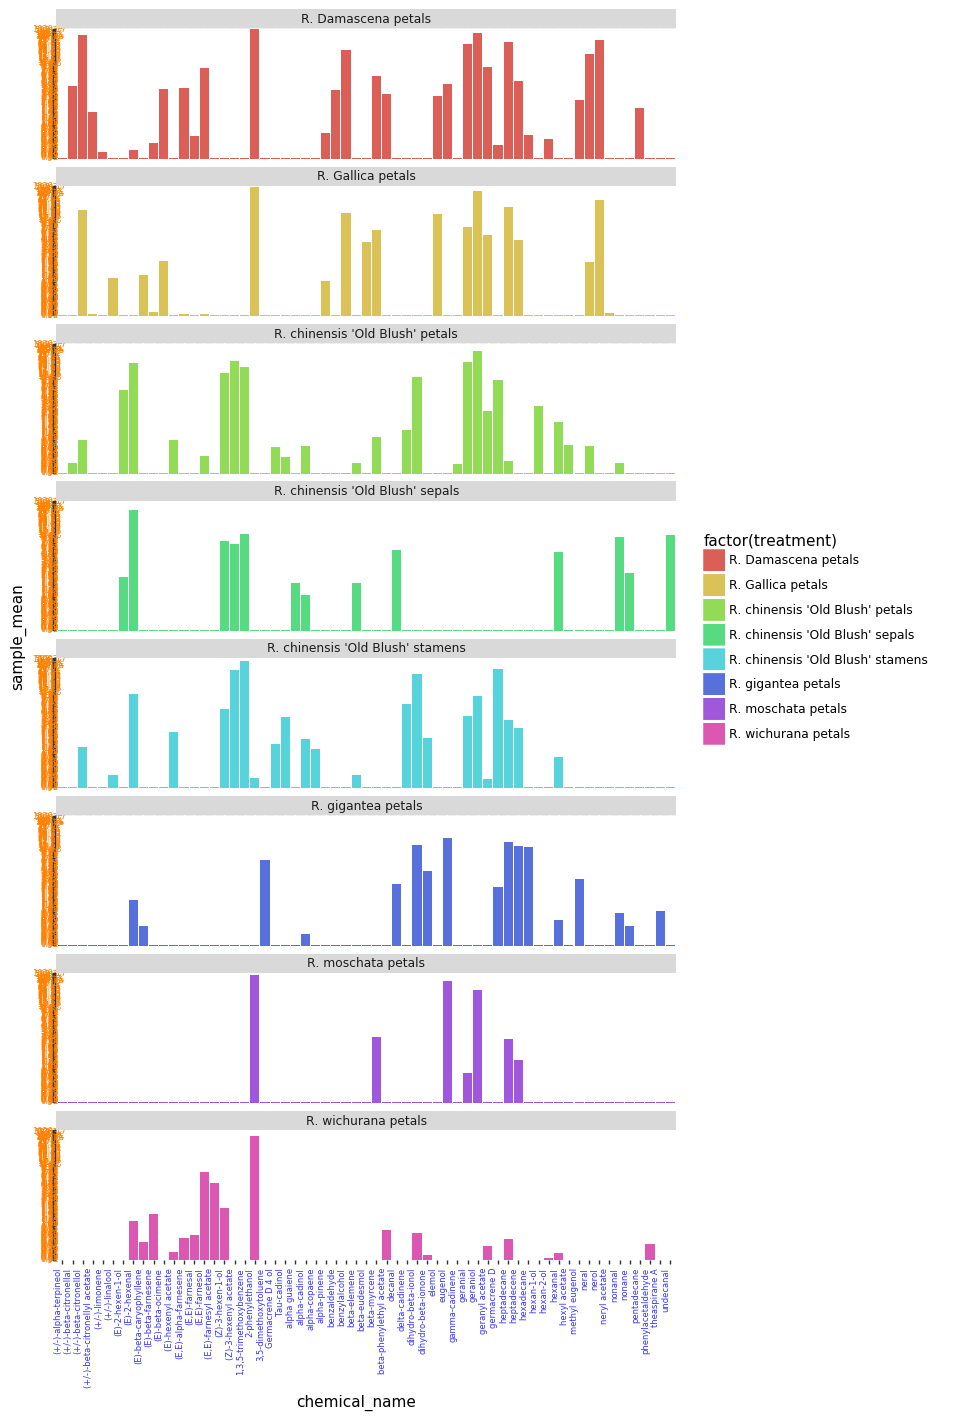

<ggplot: (-9223372036561692640)>

In [13]:
# width = figure_size[0]
# height = figure_size[0] * aspect_ratio
gray = '#666666'
orange = '#FF8000'
blue = '#3333FF'

p1 = (ggplot(data)
 + aes('chemical_name', 'sample_mean',fill='factor(treatment)')
 + geom_col()
+ facet_wrap('~treatment', dir='v',ncol=1)
# + scale_y_continuous(expand = (0,0))
 + theme(axis_text_x=element_text(rotation=90, hjust=1, fontsize=6, color=blue))
 + theme(axis_text_y=element_text(rotation=0, hjust=2, fontsize=6, color=orange))
         + theme(figure_size = (8, 16))
)

p1 + theme(panel_background=element_rect(fill=blue)
       )

p1